# Retrieve MagLim maps from Butler

## 1. Initialization

### 1.1 Import packages

In [1]:
from lsst.daf.butler import Butler
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

## 2. Retrieve maglim maps from butler

### 2.1 Define bands to get maglim maps from.

In [2]:
bands = ["u", "g", "r", "i", "z", "y"]

### 2.2 Retrieve maps

In [3]:
### Call butler
butler = Butler("dp1", collections="LSSTComCam/DP1")

### Get maps
maglim_maps = {}

for band in bands:
    maglim_maps[band] = butler.get(
        "deepCoadd_psf_maglim_consolidated_map_weighted_mean",
        skymap="lsst_cells_v1",
        band=band
    )


In [4]:
maglim_maps["r"]

HealSparseMap: nside_coverage = 32, nside_sparse = 32768, float64, 2873337 valid pixels

## 3. Clip the maps and turn them into proper work frames, with Healpix

### 3.1 Define circular aperture to clip

In [79]:
# ECDFS
target_ra = 53.131833
target_dec = -28.090806
target_r = 1.0

In [80]:
# RA/Dec grid
n = 1000 # n_pixels
ra = np.linspace(target_ra - target_r, target_ra + target_r, n)
dec = np.linspace(target_dec - target_r, target_dec + target_r, n)
ra_grid, dec_grid = np.meshgrid(ra, dec)

# Circular mask
dist = np.sqrt(
    ((ra_grid - target_ra) * np.cos(np.deg2rad(target_dec)))**2 +
    (dec_grid - target_dec)**2
)
mask = dist <= target_r


### 3.2 Clip

In [81]:
maglim_grids = {}

for band, hspmap in maglim_maps.items():
    vals = hspmap.get_values_pos(
        ra_grid[mask],
        dec_grid[mask]
    )
    maglim_grids[band] = vals

for band in maglim_grids:
    invalid = maglim_grids[band] < -1e20
    maglim_grids[band][invalid] = np.nan

In [82]:
maglim_grids["r"]

array([nan, nan, nan, ..., nan, nan, nan], shape=(846552,))

In [83]:
### Get pixels within the sky disk

nside = maglim_maps["r"].nside_sparse

vec = hp.ang2vec(
    np.deg2rad(90 - target_dec),
    np.deg2rad(target_ra)
)

ipix_disc = hp.query_disc(
    nside,
    vec,
    np.deg2rad(target_r),
    inclusive=True
)


## 4. Plot to check results

Text(0, 0.5, 'N')

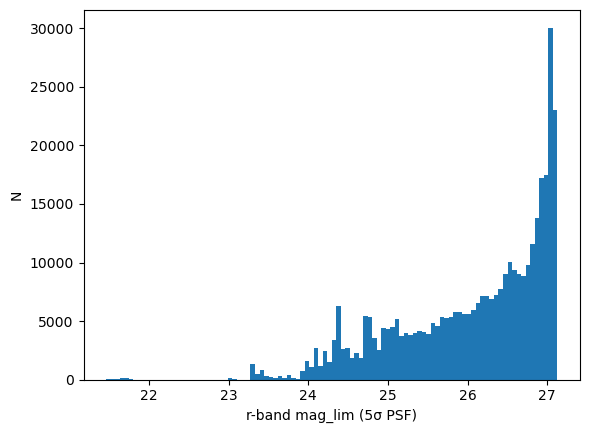

In [84]:
plt.hist(maglim_grids["r"], bins=100)
plt.xlabel("r-band mag_lim (5σ PSF)")
plt.ylabel("N")


In [100]:
# Init 2D grid
maglim_grid = np.full(ra_grid.shape, np.nan)

filter = "y"

# Evaluate the map over the grid
vals = maglim_maps[f'{filter}'].get_values_pos(
    ra_grid[mask],
    dec_grid[mask]
)

# Clean error values
vals[vals < -1e20] = np.nan

# Inject into grids
maglim_grid[mask] = vals


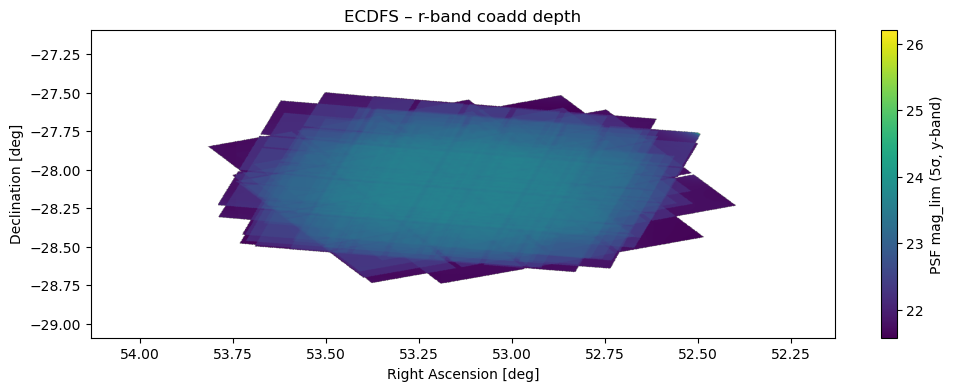

In [101]:
plt.figure(figsize=(12, 4))

im = plt.imshow(
    maglim_grid,
    origin="lower",
    extent=[ra.max(), ra.min(), dec.min(), dec.max()],
    cmap="viridis",
    aspect="auto"
)

plt.colorbar(im, label=f"PSF mag_lim (5σ, {filter}-band)")
plt.xlabel("Right Ascension [deg]")
plt.ylabel("Declination [deg]")
plt.title("ECDFS – r-band coadd depth")

plt.show()


## 5. Download to fits file

In [102]:
from astropy.wcs import WCS

dra = ra[1] - ra[0]
ddec = dec[1] - dec[0]

w = WCS(naxis=2)
w.wcs.crval = [target_ra, target_dec]
w.wcs.crpix = [len(ra)/2, len(dec)/2]
w.wcs.cdelt = [dra, ddec]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

hdu = fits.PrimaryHDU(
    data=maglim_grid,
    header=w.to_header()
)

hdu.header["COMMENT"] = "PSF 5-sigma depth map from LSST DP1"
hdu.header["BAND"] = "r"

hdu.writeto(f"ECDFS_maglim_{filter}.fits", overwrite=True)
